## Chapter 11: Principles of Feature Learning

# 11.2 Universal Approximators

In the previous Chapter we described how to engineer appropriate nonlinear features ourselves to match the patterns we gleamed in simple datasets. However very rarely in practice can we design perfect or even strongly-performing nonlinear features by completely relying on our own understanding of a dataset, whether this is gained by
visualizing the data, philosophical reflection, or domain expertise.

In this Section we jettison the unrealistic assumption that proper
nonlinear features can be engineered in the manner described in the previous Chapter, and replace it with an equally unrealistic assumption that has far more practical repercussions (as we will see in the forthcoming Sections): that we have *complete* and *noiseless* access to the phenomenon generating our data. Here we will see, in the case where we have such unfettered access to data, that absolutely perfect features can be *learned* automatically by combining elements from a set of basic feature transformations, known as *universal approximators*. In this Section we will also see elementary exemplars from the three most popular universal approximators, namely, *fixed-shape approximators*, *neural networks*, and *trees*.

For the sake of simplicity we will restrict our discussion to nonlinear regression and two-class classification, which as we saw in Chapter 10, share the same generic nonlinear model, formed as a linear combination of $B$ nonlinear feature transformations of the input

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B. 
\label{equation:section-11-1-generic-nonlinear-model}
\end{equation}

Recall that with nonlinear two-class classification, we simply pass the nonlinear regression model above through the mathematical sign function to make binary predictions. While our focus in this Section will be on these two supervised problems, because the general nonlinear model above is used in virtually all other forms of nonlinear learning including multi-class classification (see [Section 10.5](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_5_Multiclass.html) and unsupervised learning (see [Section 10.6](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_6_Unsupervised.html)), the thrust of the story unveiled here holds more generally for all machine learning problems.

In [27]:
# This code cell will not be shown in the HTML version of this notebook
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_11_library') 
sys.path.append('./chapter_11_images') 
sys.path.append('./chapter_11_datasets') 

# backend file
import section_11_2_helpers

# data path
data_path_1 = 'chapter_11_datasets/sin_function.csv'

# image paths
image_path_1 = "chapter_11_images/Figure_11_1.png"
image_path_2 = "chapter_11_images/Figure_11_2.png"
image_path_3 = "chapter_11_images/Figure_11_3.png"
image_path_4 = "chapter_11_images/Figure_11_4.png"
image_path_5 = "chapter_11_images/Figure_11_5.png"
image_path_6 = "chapter_11_images/Figure_11_6.png"
image_path_7 = "chapter_11_images/Figure_11_7.png"
image_path_8 = "chapter_11_images/Figure_11_8.png"
image_path_9 = "chapter_11_images/Figure_11_9.png"
image_path_10 = "chapter_11_images/Figure_11_10.png"
image_path_11 = "chapter_11_images/Figure_11_11.png"
image_path_12 = "chapter_11_images/Figure_11_15.png"
image_path_13 = "chapter_11_images/Figure_11_17.png"

# video paths
video_path_1 = 'chapter_11_videos/animation_1.mp4'

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perfect data as a continuous function

We now start by imagining the impossible, a *perfect* dataset for regression or two-class classification. In both cases such a dataset has two important characteristics: it is *completely noiseless* and *infinitely large*. Being completely noiseless, the first characteristic means that we could completely trust the quality of every one of its input/output pairs. Being infinitely large, means that we have unfettered access to every input/output pair $\left(\mathbf{x}_p,\,y_p\right)$ of the dataset that could possibly exist. Combined, such a dataset *perfectly* describes the phenomenon
that generates it.

In the top panels of [Figure 11.3](#figure-11-3) we illustrate what such a perfect dataset would look like in the simplest instance where the input/output data is related linearly. Starting in the left panel we show a *realistic* dataset (the kind we deal with in practice) that is both *noisy* and *small*. In the middle panel we show the same dataset, but with the noise removed from each output. In the right panel we depict a *perfect* dataset by adding all missing points from the line to the noiseless data in the middle panel, making the data appear as a *continuous* line (or hyperplane, in higher dimensions). In the bottom panels of [Figure 11.3](#figure-11-3) we show a similar transition for a prototypical nonlinear regression dataset wherein the perfect data (shown in the right-most panel) carves out a *continuous* nonlinear curve (or surface, in higher dimensions).

---

In [2]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="80%" height="auto" alt=""/>''')

<a id='figure-11-3'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.3 </strong> <em> 
(top left panel) A prototypical realistic linear regression dataset is a noisy and (relatively) small set of points that can be roughly modeled by a line. (top middle panel) The same dataset with all noise removed from their output, making all data points lie perfectly on some line. (top right panel) The perfect linear regression dataset where we have
infinitely many points lying precisely on a line. (bottom left panel) A prototypical realistic nonlinear regression dataset is a noisy and (relatively) small set of points that can be roughly modeled by a nonlinear curve. (bottom middle panel) All noise removed from the output, making all points lie perfectly on some curve, creating a noise-free
dataset. (bottom right panel) The perfect nonlinear regression dataset
where we have infinitely many points lying precisely on a curve.
</em>
</figcaption>
</figure>

---

In the same vein a perfect two-class classification dataset (using label values $y_p \in \left\{-1,+1\right\}$ by default) would appear as a general step function with an arbitrary boundary between its top and bottom steps. In the simplest case where some linear boundary separates the two steps, it consists of two contiguous portions, the bottom and top step, separated by a linear boundary. In the general nonlinear case, these two steps are separated by some nonlinear boundary. Both of these prototypical instances are illustrated in [Figure 11.4](#figure-11-4), which mirrors very closely what we saw with regression in [Figure 11.3](#figure-11-3).

---

In [3]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="80%" height="auto" alt=""/>''')

<a id='figure-11-4'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.4 </strong> <em> 
(top left panel) A prototypical realistic linear two-class classification dataset is a noisy and (relatively) small set of points that can be roughly modeled by a step function with linear boundary. (top middle panel) We progress to remove all noise from those
points by returning the true label values to our noisy points. (top right panel) The perfect linear two-class classification dataset where we have infinitely many points
lying precisely on a step function with linear boundary. (bottom left panel) A prototypical realistic nonlinear two-class classification dataset is a noisy and (relatively) small set of points that can be roughly modeled by a step function with nonlinear boundary. (bottom middle panel) We progress to remove all noise from those points, creating a noise-free dataset. (bottom right panel) The perfect nonlinear two-class classification dataset where we have infinitely many points lying precisely on a step function with nonlinear boundary.
</em>
</figcaption>
</figure>

---

In short, a perfect regression or two-class classification dataset is a continuous function with unknown equation. Because of this we will refer to our perfect data using the function notation $y\left(\mathbf{x}\right)$, meaning that the data pair defined at input $\mathbf{x}$ can be written as either $\left(\mathbf{x},y\left(\mathbf{x}\right)\right)$ or likewise $\left(\mathbf{x},y\right)$.  

It is important to bear in mind that the function notation $y\left(\mathbf{x}\right)$ does not imply that we have knowledge of a closed form *formula* relating the input/output pairs of a perfect dataset, we do not! Indeed our aim next is to understand how such a formula can be devised to adequately represent a perfect dataset.

## The spanning set analogy for universal approximation

Here we will leverage our knowledge and intuition about basic linear algebra concepts such as vectors, spanning sets, and the like (see [Section 10.2](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_2_Spanning.html) to better understand how we can combine nonlinear functions to model perfect regression and classification data. In particular we will see how vectors and nonlinear functions are very much akin when it comes to the notions of linear combination and spanning sets.

### Linear combinations of vectors and functions

To begin, assume we have a set of $B$ vectors $\left\{\mathbf{f}_1,\,\mathbf{f}_2,\,\ldots,\,\mathbf{f}_B\right\}$, each having dimension $N$. We call this a *spanning* set of vectors. Then, given a particular set of weights $w_1$ through $w_B$, the linear combination 


\begin{equation}
\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B = \mathbf{y}
\label{equation:linear-combination-vectors}
\end{equation}

defines a new $N$ dimensional vector $\mathbf{y}$. This is illustrated in the top row of [Figure 11.5](#figure-11-5) for a particular set of vectors and weights where $B=3$ and $N=3$.

The arithmetic of nonlinear functions works in an entirely similar manner: given a spanning set of $B$ nonlinear functions $\left\{f_1\left(\mathbf{x}\right),\,f_2\left(\mathbf{x}\right),\,\ldots,\,f_B\left(\mathbf{x}\right)\right\}$ (where the input $\mathbf{x}$ is $N$ dimensional and output is scalar) and a corresponding set of weights, the linear combination

\begin{equation}
 w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B = y\left(\mathbf{x}\right)
 \label{equation:linear-combination-functions}
 \end{equation}
 
 defines a new function $y\left(\mathbf{x}\right)$. This is illustrated in the bottom row of [Figure 11.5](#figure-11-5) for a particular set of functions and weights where $B=3$ and $N=1$.

---

In [4]:
IPython.display.HTML('''<img src="''' + image_path_3 + '''" width="80%" height="auto" alt=""/>''')

<a id='figure-11-5'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.5 </strong> <em> 
top row) A particular linear combination of the three vectors in black creates a new vector (shown in blue). (bottom row) In an entirely similar fashion a particular linear combination of three functions in black creates a new function (shown in blue).
</em>
</figcaption>
</figure>

---

Notice the similarity between the vector and function arithmetic in Equations (2) and (3): taking a particular linear combination of a set of vectors creates a new vector with qualities inherited from each vector $\mathbf{f}_b$ in the set, just as taking a linear combination of a set of functions creates a new function taking on qualities of each function $f_b\left(\mathbf{x}\right)$ in that set. One difference between the two linear combination formulae is the presence of a *bias parameter* $w_0$ in Equation (3). This bias parameter could be rolled into one of the nonlinear functions and not made explicit (by adding a constant function to the mix), but we choose to leave it out-front of the linear combination of functions (as we did with linear models in previous Chapters). As illustrated in [Figure 11.6](#figure-11-6) this bias parameter is responsible for moving our linear combination of functions vertically along the output axis.

---

In [6]:
IPython.display.HTML('''<img src="''' + image_path_4 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-6'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.6 </strong> <em> 
The bias parameter $w_0$ in Equation (3) controls the vertical placement of our linear combination of functions (depicted in black in the left column). (top panel) When it is set to a negative number the bias moves the linear combination down. (bottom panel) Conversely, when set to a positive number the bias moves the entire linear combination upwards.
</em>
</figcaption>
</figure>

---

##  Capacity of spanning sets

Computing the vector $\mathbf{y}$ in Equation (2), for a *given* set of weights $w_1$ through $w_B$, is a trivial affair. The inverse problem on other hand, i.e., finding the weights given $\mathbf{y}$, is slightly more challenging. Stated algebraically, we want to find the weights $w_1$ through $w_B$ such that 

\begin{equation}
\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}
\label{equation:chap-11-vector-based-approximation}
\end{equation}

holds as well as possible. This is illustrated for a simple example in the top row of [Figure 11.7](#figure-11-7).

---

In [7]:
IPython.display.HTML('''<img src="''' + image_path_5 + '''" width="90%" height="auto" alt=""/>''')

<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.7 </strong> <em> 
(top panels) An $N=3$ dimensional vector $\mathbf{y}$ (shown in red in the first panel from the left) is approximated using one (second panel from the left), two (third panel from the left), and three (fourth panel from the left) spanning vectors (here, standard basis vectors). As the number of vectors increases we can approximate $\mathbf{y}$ with greater precision. (bottom panels) The same concept holds with functions as well. A continuous function with scalar input $y\left(\mathbf{x}\right)$ (shown in red) is approximated using one (second panel from the left), two (third panel from the left), and three (fourth panel from the left) spanning functions (here, sine waves of varying frequency). As the number of functions increases we can approximate $y\left(\mathbf{x}\right)$ with greater precision.
</em>
</figcaption>
</figure>

---

How well the *vector approximation* in Equation (2) holds depends on three crucial and interrelated factors: (1) the diversity (i.e., linear independence) of the spanning vectors, (2) the number $B$ of
them used (in general the larger we make $B$ the better), and (3) how well we tune the weights $w_1$ through $w_B$ via minimization of an appropriate cost\footnote{For instance, the Least Squares cost: $\left\Vert\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B - \mathbf{y}\right\Vert _2^2$.}.

Factors (1) and (2) determine a spanning set's *rank* or *capacity*, that is a measure for the range of vectors $\mathbf{y}$ we can possibly represent with such a spanning set. A spanning set with a *low capacity*, that is one consisting of a non-diverse and/or a small number spanning vectors can approximate only a tiny fraction of those present in the entire vector space. On the other hand, a spanning set with a *high capacity* can represent a broader swath of the space. The notion of capacity for a spanning set of vectors is illustrated for a particular spanning set in the top row of [Figure 11.8](#figure-11-8).  

---

In [8]:
IPython.display.HTML('''<img src="''' + image_path_6 + '''" width="90%" height="auto" alt=""/>''')

<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.8 </strong> <em> 
(top panels) As we increase the number of diverse vectors in a spanning set, from one in the left panel to two and three in the middle and right panels respectively, we increase the capacity of the spanning set. This is reflected in the increasing diversity of sample vectors created using each spanning set (shown in different shades of blue). (bottom panels) The analogous situation with functions. As we increase the number of diverse functions in the spanning set, from a single function in the left panel to two and three functions in the middle and right panels respectively, we increase the spanning set's capacity. This is reflected in the increasing diversity of sample functions created using each spanning set (shown in different shades of blue).
</em>
</figcaption>
</figure>

---

Turning our attention from vectors to functions, notice that computing the function $y\left(\mathbf{x}\right)$ in Equation (3) for a *given* set of weights $w_1$ through $w_B$ is straightforward. As with the vector case, we can reverse this problem and try to find the weights $w_1$ through $w_B$, for a given $y\left(\mathbf{x}\right)$, such that 

\begin{equation}
 w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B \approx y\left(\mathbf{x}\right)
\label{equation:chap-11-function-based-approximation}
 \end{equation}

holds as well as possible.  This is illustrated for a simple example in the bottom row of [Figure 11.8](#figure-11-8).

Once again, how well this *function approximation* holds depends on three crucial and interrelated factors: (1) the diversity of the spanning functions, (2) the number $B$ of them functions used, and (3) how well we tune the weights $w_0$ through $w_B$ (as
well as any parameters internal to our nonlinear functions) via minimization of an appropriate cost. In analogy to the vector case, factors (1) and (2) determine the *capacity* of a spanning set of functions. A *low capacity* spanning set that uses a non-diverse and/or small array of nonlinear functions is only capable of representing a small range of nonlinear functions. On the other hand, a spanning set with a *high capacity* can represent a wider swath of functions.  The notion of capacity for a spanning set of functions is illustrated for a particular spanning set in the bottom row of [Figure 11.9](#figure-11-9).  

Sometimes the spanning functions $f_1$ through $f_B$ are parameterized, meaning that they have internal parameters themselves. An unparameterized spanning function is very much akin to a spanning vector, as they are both parameter-free. A parameterized spanning function on the other hand can take on a variety of shapes alone, and thus can itself have high capacity. The same cannot be said about spanning vectors and unparameterized spanning functions. This concept is illustrated in [Figure 11.9](#figure-11-9) where in the left column we show an ordinary spanning vector $\mathbf{x}$ (top left panel) along with an unparameterized spanning function, i.e., $\text{sin}\left(x\right)$ (bottom left panel). In the bottom right panel of the Figure we show the parameterized function $\text{sin}\left(wx\right)$ which can represent a wider range of different functions as its internal parameter $w$ is adjusted. Thinking analogously, we can also parameterize the spanning vector $\mathbf{x}$, e.g., via multiplying it by the rotation matrix

\begin{equation}
R_{w}=\left[\begin{array}{cc}
\text{cos}(w) & -\text{sin}(w)\\
\text{sin}(w) & \text{cos}(w)
\end{array}\right]
\label{equation:rotation-matrix}
\end{equation}

that allows it to rotate in the plane and represent a range of different vectors depending on how the rotation angle $w$ is set.

---

In [10]:
IPython.display.HTML('''<img src="''' + image_path_7 + '''" width="90%" height="auto" alt=""/>''')

In [12]:
IPython.display.HTML('''<img src="''' + image_path_9 + '''" width="80%" height="auto" alt=""/>''')

<a id='figure-11-9'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.9 </strong> <em> 
(top left panel) An ordinary spanning vector. (bottom left panel) An unparameterized spanning function. (bottom right panel) A parameterized spanning function with a single internal parameter. By changing the value of this internal parameter it can be made to take on a range of shapes. (top right panel) A parameterized spanning vector pre-multiplied by the rotation matrix in Equation (6) whose angle of rotation $w$ ranges over a set of values.
</em>
</figcaption>
</figure>

---

### Universal approximation

In the case of vector-based approximation in Equation (4) if we choose $B \geq N$ vectors for our spanning set, and at least $N$ of them are linearly independent, then our spanning set has maximal capacity and we can therefore approximate *every* $N$ dimensional vector $\mathbf{y}$ to *any* given precision, provided we tune the parameters of the linear combination properly. Such a set of spanning vectors, of which there are infinitely many for an $N$ dimensional vector space, can approximate (or in this case perfectly represent) every vector *universally*, and is thus sometimes referred to as a *universal approximator*. For example, the simple standard basis for a vector space is a common example of a spanning set that is a universal approximator. This notion of universal approximation of vectors is illustrated in the left panel of [Figure 11.10](#figure-11-10).

---

In [14]:
IPython.display.HTML('''<img src="''' + image_path_10 + '''" width="75%" height="auto" alt=""/>''')

<a id='figure-11-10'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.10 </strong> <em> 
(top panel) Universal approximation illustrated in the vector case. (top row) A universal approximator spanning set consisting of three vectors, shown in black.  (middle row) Three example vectors to approximate colored red, yellow, and blue, from left to right. (bottom row) The approximation of each vector in the middle row using the spanning set in the top row, shown in black in each instance. This approximation can be made perfect, but for visualization purposes is shown slightly offset here. (bottom panel) The analogous universal approximation scenario illustrated for functions. (top row) A universal approximator spanning set consisting of three functions (in practice many more spanning functions may be needed than shown here). (middle row) Three example functions to approximate colored red, yellow, and blue, from left to right. (bottom row) The approximation of each function in the middle row using the spanning set in the top row, shown in black in each instance.
</em>
</figcaption>
</figure>

---

The precise analogy holds with function approximation in Equation (5) as well. If we choose the right kind of spanning functions, then our spanning set has maximal capacity and we can therefore approximate *every* function $y\left(\mathbf{x}\right)$ to *any* given precision, provided we tune the parameters of the linear combination properly. Such a set of spanning functions, of which there are infinitely many varieties, can approximate every function *universally*, and is thus often referred to as a *universal approximator*. This notion of universal approximation of functions is illustrated in the right panel of [Figure 11.10](#figure-11-10).

One difference between the vector and the function regime of universal approximation is that with the latter we may need infinitely many spanning functions to be able to approximate a given function to an arbitrary precision (whereas with the former it is always sufficient to set $B$ greater than or equal to $N$). [Example 11.1](#example-11-1) gives an intuitive explanation of this fact.  

---

<a id='example-11-1'></a>
#### <span style="color:#a50e3e;">Example 11.1:</span>  Functions as infinite dimensional vectors

That the notions of vector arithmetic, capacity, and universal approximation generalize to the case of functions can also be intuited (albeit in a non-rigorous way) by thinking about functions as *infinite dimensional vectors*. 

As illustrated in the top row of [Figure 11.11](#figure-11-11), any $N$ dimensional vector $\mathbf{y}$ can be viewed as the *output* of a generic function by pairing it with a corresponding $N$ dimensional *input* vector $\mathbf{x}$ consisting of evenly spaced entries on the unit interval $\left[0,\,1\right]$ (i.e., its $n^{th}$ entry is $x_n = \frac{n}{N}$). In this case the corresponding function defined by set of input/output points $\left\{\left(x_{n},\,y_{n}\right)\right\} _{n=1}^{N}$ can be thought of as a discrete single-input function. As illustrated in the bottom row of Figure 11.11, as $N \longrightarrow \infty$ this discrete function (roughly speaking) approaches a continuous function.

---

In [15]:
IPython.display.HTML('''<img src="''' + image_path_11 + '''" width="80%" height="auto" alt=""/>''')

<a id='figure-11-11'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.11 </strong> <em> 
(top row)  A generic vector $\mathbf{y}$ represented as the output of a regression dataset with evenly spaced input (see text for further details). (bottom row) The $N$ dimensional $\mathbf{y}$ with entries
$y_{n}=\text{sin}\left(2\pi x_{n}\right)$ where $x_{n}=\frac{n}{N}$
and $1 \leq n \leq N$, plotted as points $\left(x_{n},\,y_{n}\right)$ with increasing values of $N$ from left to right. The vector
$\mathbf{y}$, as a discrete function, closely resembles the continuous
function $y\left(x\right)=\mbox{sin}\left(2\pi x\right)$, especially as $N$ grows large.
</em>
</figcaption>
</figure>

---

##  Popular universal approximators

When it comes to approximating functions there is an enormous variety of spanning sets that are *universal approximators*. Indeed, just as in the vector case, with functions there are infinitely many universal approximators. However for the purposes of organization, convention, as well as a variety of technical matters universal approximators used in machine learning are often lumped into three main categories referred to as *fixed-shape approximators*, *neural networks*, and *trees*.  Here we introduce only the most basic exemplar from each of these three categories, which we will reference throughout the remainder of the Chapter. Each of these popular families has its own unique practical strengths and weaknesses as a universal approximator, a wide range of technical details to explore, and conventions of usage. 

---

#### <span style="color:#a50e3e;">Example 11.3:</span>  The fixed-shape family of universal approximators

The family of *fixed-shape* functions consists of groups of nonlinear
functions with no internal parameters, a popular example being *polynomials*. When dealing with just one input this sub-family of fixed-shape functions looks like

\begin{equation}
f_1(x) = x, ~~ f_2(x) = x^2,~~ f_3(x)=x^3,~~ \text{etc.},
\end{equation}

with the $D^{th}$ element taking the form
$f_D(x) = x^D$.  A combination of the first $D$ units from this
sub-family is often referred to as a *degree $D$* polynomial.
 There are an infinite number of these functions (one for each positive whole number $D$) and they are *naturally ordered* by their degree. The fact that these functions have no tunable internal parameters gives each a *fixed shape* as shown below.

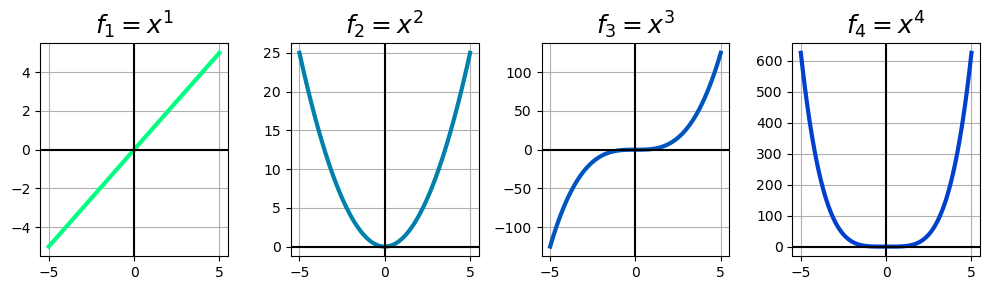

In [19]:
## This code cell will not be shown in the HTML version of this notebook
# build the first 4 non-constant polynomial basis elements
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    fm = x**m
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],color = [0,1/float(m),m/float(m+1)],linewidth = 3)
    ax.set_title('$f_'+str(m) + ' = x^' + str(m) + '$',fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
plt.show()

With two inputs $x_1$ and $x_2$, a general degree $D$ polynomial unit takes the analogous form

\begin{equation}
f_b(x_1,x_2) = x_1^px_2^q 
\label{equation:degree-two-polynomial}
\end{equation}

where $p$ and $q$ are non-negative integers and $p + q \leq D$. Classically, a degree $D$ polynomial is a linear combination of all such units. Furthermore, this definition directly generalizes to $N>2$ dimensional input as well. Fixed-shape approximators are discussed in much greater detail in Chapter 12.

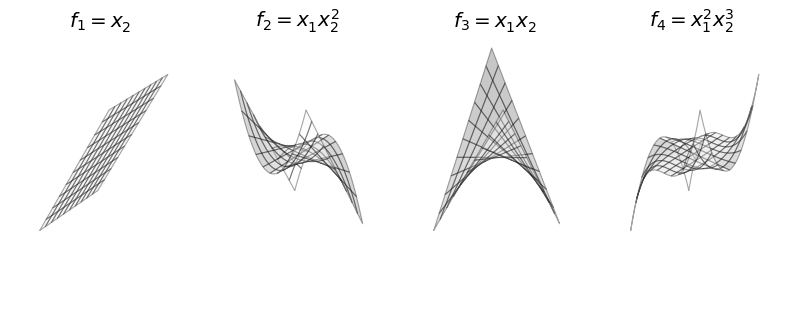

In [20]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    f_m = (x_1**p[m])*(x_2**q[m])
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40)  
    deg1 = ''
    if p[m] == 1:
        deg1 = 'x_1^{\,}'
    if p[m] >=2:
        deg1 = 'x_1^' + str(p[m])
    deg2 = ''
    if q[m] == 1:
        deg2 = 'x_2^{\,}'
    if q[m] >=2:
        deg2 = 'x_2^' + str(q[m])
    ax1.set_title('$f_'+str(m+1) + ' = ' + deg1 + deg2 + '$',fontsize = 18)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

#### <span style="color:#a50e3e;">Example 11.4:</span>  The neural network family of universal approximators

Another popular family of universal approximators are *neural networks*. Broadly speaking neural networks consist of *parameterized* functions, allowing them to take on a variety of different shapes (unlike the fixed-shape functions described previously, each of which takes on a single fixed form). 

The simplest kind of neural networks universal approximator is a parameterized elementary function like a logistic sigmoid, $tanh$, or rectified linear unit. For example using the $tanh$ function, a universal approximator of so-called *single-layer* (also called *single-hidden-layer*) neural network units consists of nonlinear features of the form

\begin{equation}
f_1(x) = \text{tanh}\left(w_{1,0} + w_{1,1}x\right), ~~ f_2(x) = \text{tanh}\left(w_{2,0} + w_{2,1}x\right), ~~ \text{etc.} 
\label{equation:tanh-1-layer-1d}
\end{equation}


The internal parameters $w_{b,0}$ and
$w_{b,1}$ of a generic single-layer unit $f_b(x) = \text{tanh}\left(w_{b,0} + w_{b,1}x\right)$ allow it to take on a variety of shapes. In the top row of the Figure below we illustrate this fact by taking a single one of these units, randomly setting the values of its two internal parameters, and plotting the result.

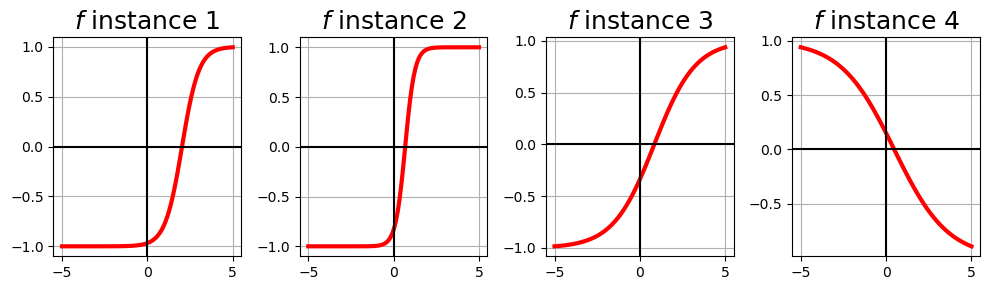

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# build 4 instances of a composition basis: line and tanh
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    fm = np.tanh(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],c='r',linewidth = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

To construct neural network features taking in higher dimensional input we take a linear combination of the input and pass the result through the nonlinear function.  For example, an element $f_b$ for general $N$ dimensional input takes the form

\begin{equation}
f_b\left(\mathbf{x}\right) = \text{tanh}\left(w_{b,0} + w_{b,1}x_1 + \cdots + w_{b,\,N}x_N\right).
\label{equation:tanh-1-layer-Nd}
\end{equation}

As with the lower dimensional example, each function above can take on a variety of different shapes, as illustrated in the bottom row of the Figure below, based on how we tune its internal parameters. Neural network approximators are described in much greater detail in Chapter 13.

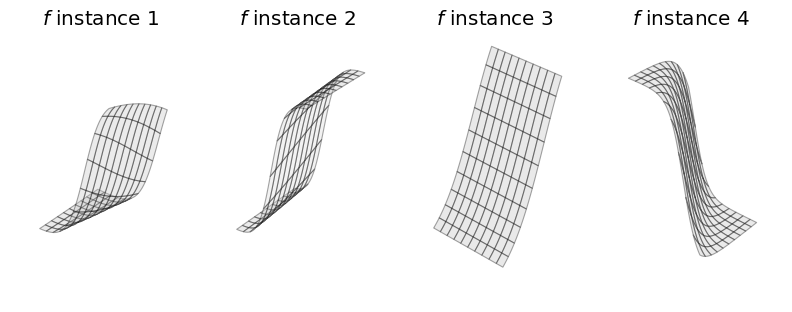

In [23]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    w_3 = np.random.randn(1)
    f_m = w_3*np.tanh(w_0 + w_1*x_1 + w_2*x_2)

    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

#### <span style="color:#a50e3e;">Example 11.5:</span>  The trees family of universal approximators

Like neural networks, a single element from the family of tree-based
universal approximators can take on a wide array of shapes. The simplest sort of tree unit consists of discrete step functions or, as they are more commonly referred to, *stumps* whose break lies along a single dimension of the input space. A stump with one dimensional input $x$ can be written as

\begin{equation}
f\left(x\right)=\begin{cases}
\begin{array}{c}
v_{1}\\
v_{2}
\end{array} & \begin{array}{c}
x<s\\
x>s
\end{array}\end{cases}
\label{equation:stump-chapter-11}
\end{equation}

where $s$ is called a *split point* at which the stump changes values, and $v_{1}$ and $v_{2}$ are values taken by the two sides of the stump respectively, which we refer to as *leaves* of the stump. A tree-based universal approximator is a set of such stumps with each unit having its own unique split point and leaf values.

In the top row of Figure below we plot four instances of such a stump unit where we can see how each one takes on a wide variety of shapes. 

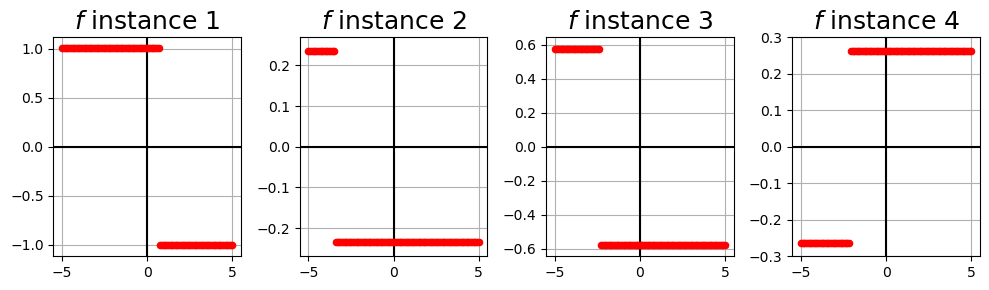

In [24]:
## This code cell will not be shown in the HTML version of this notebook
# build 4 instances of a composition basis: line and tanh
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    fm = w_2*np.sign(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.scatter(fm_table[:,0],fm_table[:,1],c='r',s = 20,zorder = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

Higher dimensional stumps follow this one dimensional pattern: a split point $v_1$ is defined along a *single* dimension, defining a linear step along a single coordinate dimension.  Each side of the split is then assigned a single level value.  Below we plot four instances of a single stump defined in two dimensions.  Here the split point is defined along a value on either the $x_1$ or $x_2$ axis, producing a step that is a line along one coordinate axes. 

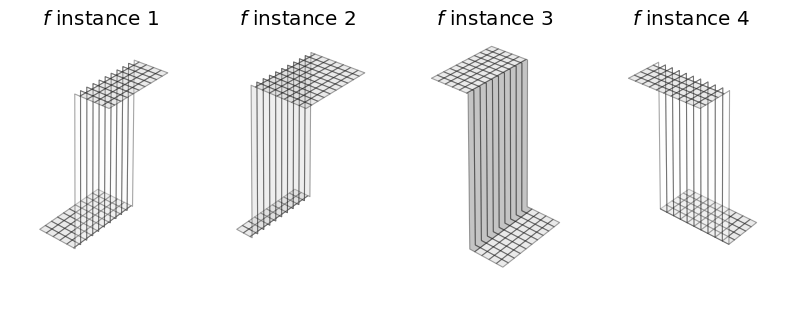

In [25]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    r = np.random.randint(2)
    w_0 = 0.1*np.random.randn(1)
    w_1 = np.random.randn(1)*r
    w_2 = np.random.randn(1)*(1 - r)
    w_3 = 3*np.random.randn(1)
    f_m = w_3*np.sign(w_0 + w_1*x_1 + w_2*x_2)
    
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

---

When forming a basic universal approximator based nonlinear model 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\label{equation:universal-approximator-model}
\end{equation}

 we always use units from a *single* type of universal approximator (e.g., all fixed-shape, neural network, or tree-based units).  We do not 'mix and match' - taking a few units from each of the main families.  As we will see in the present Chapter as well as those following this one, by restricting a model's feature transformations to a single family we can (in each of the three cases) better optimize the learning process and better deal with each family's unique technical eccentricities relating to fundamental scaling issues associated with fixed-shape units, the non-convexity of cost functions associated with neural network units, and the discrete nature of tree-based units.  On the other hand it is considerably easier to combine different models where each consists of a single type of universal approximator, as detailed later in Section 11.9.

## The capacity and optimization dials

With any of the major universal approximators introduced in the previous Subsection (whether they be fixed-shape, neural networks, or trees) we can attain universal approximation to any given precision, provided that the generic nonlinear model in Equation (3) has sufficiently large *capacity* (e.g., by making $B$ large enough), and that its parameters are tuned sufficiently well through *optimization* of an associated cost function. The notions of *capacity* and *optimization* of such a nonlinear model are depicted conceptually in [Figure 11.15](#figure-11-15) as a set of two *dials*. 

The *capacity dial* visually summarizes the amount of capacity we allow into a given model, with each notch on the dial denoting a distinct model constructed from units of a universal approximator.  When set all the way to the left we admit as little capacity as possible, i.e., we employ a *linear* model.  As we move the capacity dial from left to right (clockwise) we adjust the model, adding more and more capacity, until the dial is set all the way to the right.  When set all the way to the right we can imagine admitting an infinite amount of capacity in our model (e.g., when using an infinite number of units from a particular family of universal approximators).  

The *optimization dial* visually summarizes how well we minimize the cost function of a given model whose capacity is already set.  The setting all the way to the left denotes the initial point of whatever local optimization technique we use.  As we turn the optimization dial from left to right (clockwise) we can imagine moving further and further along the particular optimization run we use to properly tune the parameters of the model, with the final step being represented visually as the dial set all the way to the right where we imagine we have successfully minimized the associated cost function.

Note that in this conceptualization each pair of settings (of capacity and optimization dials) produces a unique tuned model: the model's overall architecture/design is decided by the capacity dial, and the set of specific values for the model parameters is determined by the optimization dial. For example, one particular setting may correspond to a model composed of $B=10$ neural networks units, whose parameters are set from taking $1000$ steps of gradient descent, while another setting corresponds to a model composed of $B=200$ neural networks units, whose parameters are set from taking only $5$ steps of gradient descent.

---

In [17]:
IPython.display.HTML('''<img src="''' + image_path_12 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-15'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.15 </strong> <em> 
Model capacity and optimization precision visualized as two dials. When the capacity dial is set to the left we have a low capacity linear model, when set to the right we admit maximum (perhaps infinite) capacity into the model. The optimization dial set to the left denotes the initial point of optimization, and all the way to the right denotes the final step of successful optimization. (top row) With linear regression (as we saw in previous Chapters) we set the capacity dial all the way to the *left* and the optimization dial all the way to the *right* in order to find the best possible set of parameters for a low capacity linear model (drawn in blue) that fits the given regression data. (bottom row) With universal approximation of a continuous function (drawn in black) we set both dials to the *right*, admitting infinite capacity into the model and tuning its parameters by optimizing to completion. See text for further discussion.
</em>
</figcaption>
</figure>

---

With these two dial conceptualizations in mind, we can think about the concept of universal approximation of a continuous function as turning *both* dials all the way to the right, as shown in the bottom row of [Figure 11.15](#figure-11-15). That is, to approximate a given continuous function using a universal approximator, we set our model capacity as *large* as possible (possibly infinitely so) turning the capacity dial all the way to the right, and optimize its corresponding cost function as *well* as possible, turning the optimization dial all the way to the right as well.

In contrast, with the sort of linear learning we have looked at in previous Chapters (as depicted in the top row of the [Figure 11.15](#figure-11-15)) we set our capacity dial all the way to the left (employing a linear model) but still set our optimization dial all the way to the right. By optimizing to completion we determine the proper bias and slopes of our linear model when performing, e.g., linear regression, as depicted in the Figure.


We now examine a number of simple examples of universal approximation using various near-perfect regression and two-class classification datasets, where we set both the capacity and optimization dials far to the right. Here *near-perfect* means a very finely sampled, large dataset (as opposed to a perfect, infinitely large one).  The case where a dataset is truly infinitely large would, in theory, require infinite computing power to minimize a corresponding cost function (e.g., imagine trying to minimize a softmax cost function over a dataset of size $P = \infty$). 

---

#### <span style="color:#a50e3e;">Example 11.5:</span>   Universal approximation of near-perfect regression data

In the animation below we illustrate universal approximation of a near-perfect regression dataset consisting of \(P = 10,000\) evenly sampled points from an underlying sinusoidal function defined over the unit interval. In the left, middle, and right panels we show the result of fitting an increasing number of polynomial, single-layer $\text{tanh}$, and stump units respectively, to this data. As we increase the number of units in each case (from top to bottom) the capacity of each corresponding model increases, allowing for a better universal approximation.  

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# produce visual comparison of different universal approximator fits
demo = section_11_2_helpers.Visualizer()
demo.load_data(data_path_1)
demo.brows_fits(savepath = video_path_1,num_elements = [v for v in range(1,71,1)],scatter = 'on',fps=5)

In [35]:
# load in video and display
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_1 + """' type="video/mp4">
  </video>
""")

Note here that it takes far fewer units of both the polynomial and $\text{tanh}$ approximators to represent the data well as compared to the discrete stumps. This is because members of the former more closely resemble the smooth sinusoidal function that generated the data in the first place. This sort of phenomenon is true in general: while any type of universal approximator can be used to approximate a perfect (or near-perfect) dataset as closely as desired, some universal approximators require fewer units to do so than the others depending on the shape of the underlying function that generated the dataset.

#### <span style="color:#a50e3e;">Example 11.6:</span>   Universal approximation of near-perfect classification data

In the top row of [Figure 11.17](#figure-11-17) we show four instances of near-perfect two-class classification data from the perceptron perspective (i.e., from the top) each consisting of $P=10,000$ points. In each instance those points colored red have label value $+1$, and
those colored blue have label value $-1$. Plotted in the second row of this Figure are the corresponding datasets shown from the regression perspective (i.e., from the side). 

Each of these near-perfect datasets can be approximated effectively using any of the three catalogs of universal approximators discussed above, provided of course that the capacity of each model is increased sufficiently and that the corresponding parameters are tuned properly. In the third and fourth rows of the Figure we show the resulting fit from employing $B = 30$ polynomial approximators using a Least Squares and softmax cost, respectively. 

---

In [18]:
IPython.display.HTML('''<img src="''' + image_path_13 + '''" width="80%" height="auto" alt=""/>''')

<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.17 </strong> <em> 
(top row) Four instances of near-perfect two-class classification data. (second row) The corresponding data shown from a different (i.e., regression) perspective. (third row) Respective polynomial approximations to each dataset with $B=30$ units in each instance using a Least Squares cost (third row) and a softmax cost (fourth row). The approximations shown in the final row are passed through the $\text{tanh}$ function before visualization. See text for further details.
</em>
</figcaption>
</figure>

---